In [10]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import json

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.api import ai_client
from src.utils import *
from src.const import *
from src.plots import *
from src.signal_providers.signal_manager import *
from src.news_providers.news_api_provider import *
from src.agents.news_filtering_agent import *
from src.agents.trading_agent import *
from src.agents.supervisor_trader import SupervisorTrader
from src.agents.marginal_agent import MarginalAgent
from src.agents.supervisor_margin_trader import SupervisorMarginTrader

%load_ext autoreload
%autoreload 2

sns.set_theme(style="darkgrid")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
coin = "DOGE"

cutoff = subtract_time(get_current_datetime(), days=20)
str(cutoff)

'2024-04-02 01:03:11.471541'

In [3]:
day_history = get_day_history(coin, cutoff)
week_history = get_week_history(coin, cutoff)
month_history = get_month_history(coin, cutoff)
year_history = get_year_history(coin, cutoff)

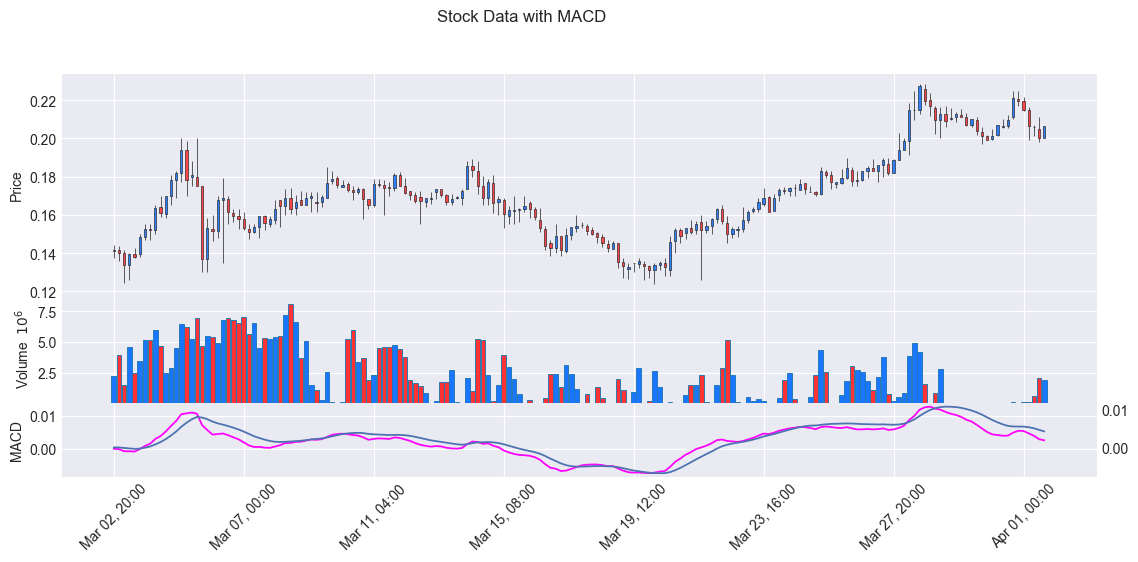

In [4]:
make_candlebars(month_history)

In [11]:
napi = NewsApi()
trading_agent = SupervisorMarginTrader()
filtering_agent = NewsFilteringAgent()

In [7]:
news = napi.get_news(coin, start_date=subtract_time(cutoff, days=10), end_date=cutoff)
filtered_news = filtering_agent.filter_news(news)
json.loads(filtered_news)

{'headlines': ['Top Crypto Gainers to Watch this Week – Dogecoin, Aptos, Toncoin and New Altcoin ICOs'],
 'sentiment': 'Neutral to Positive',
 'description': 'The crypto market experienced a mixed performance last week, with significant cryptocurrencies like Bitcoin and Ethereum showing declines. However, notable gains were seen in specific altcoins, including Toncoin. The article highlighted Toncoin as one of the top crypto gainers to watch, which suggests investor interest and potential positive movement in its market value. This mention categorizes Toncoin alongside prominent emerging crypto projects and increases visibility among potential investors, indicating a cautiously optimistic sentiment in the market surrounding Toncoin and similar altcoins.'}

In [12]:
balance = {coin: 0, "USDT": 100}
operations_history = []

[{'role': 'system', 'content': "You are professional futures trader with an extensive understanding of cryptocurrency markets. \n                \n                Respond with JSON of described format.\n                Guidelines:\n                - Do not buy on everything you have, distribute spendings!\n                - Feel free to sell all if selling improves total net_worth of acccount\n                - Consider historical market data and recent news.\n                - Use only money from your 'balance'\n                \n                Your ultimate goal is to make make as much profit as possible\n                "}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is price history of this coin in the last day. Current price: 0.20079022'}, {'type': 'image_url', 'image_url': {'url': '', 'detail': 'high'}}]}, {'role': 'user', 'content': [{'type': 'text', 'text': 'This is price history of this coin in the last week'}, {'type': 'image_url', 'image_url': {'url': '', 'd
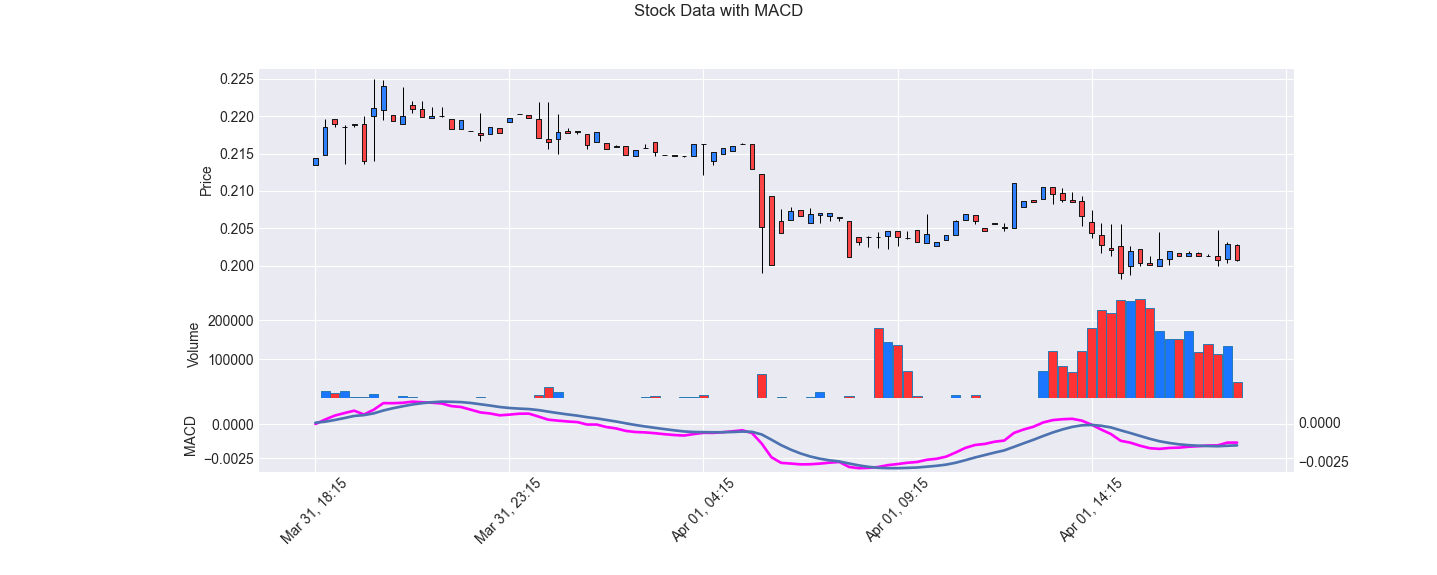
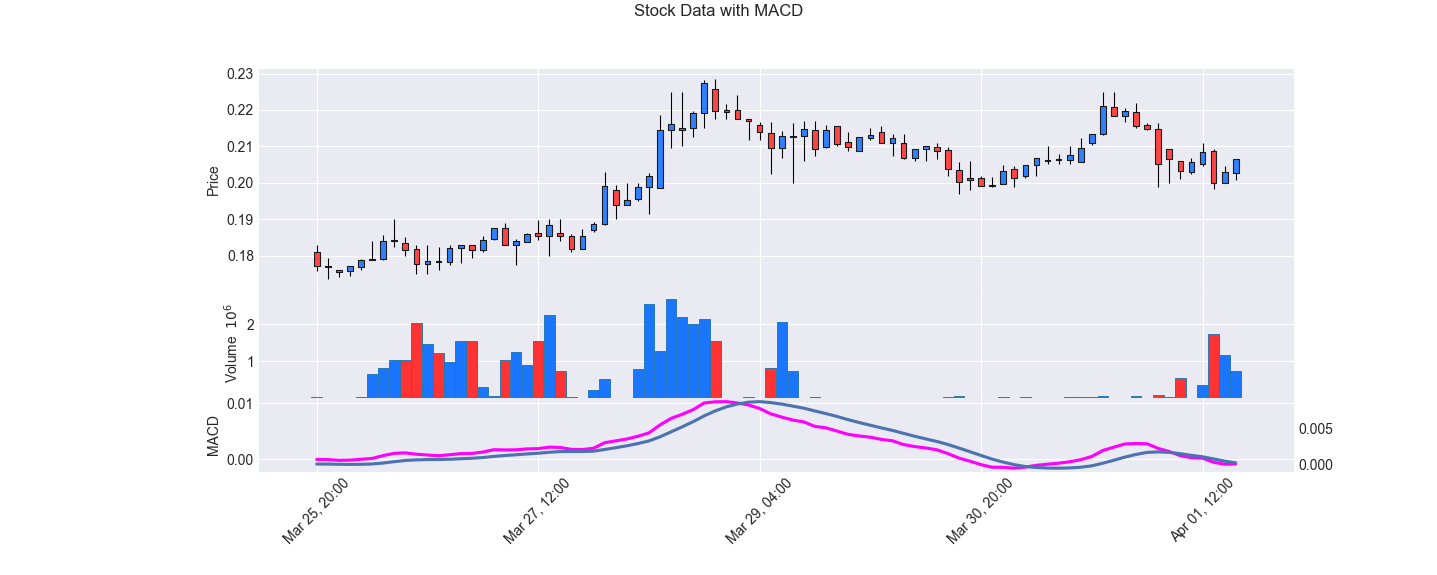
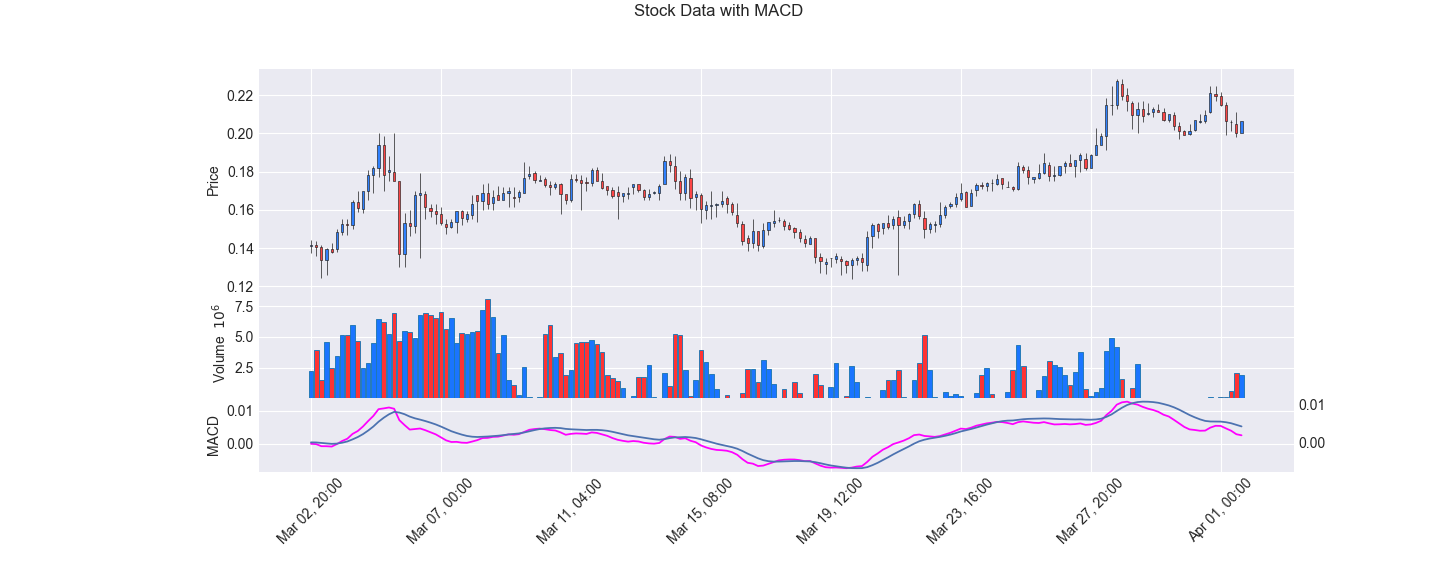

{'strategy_evaluation': 'The buying strategy appears logical given the current market conditions which show a slightly positive sentiment without strong bearish trends, potentially allowing for upside growth. The risk management using a stop-loss mitigates significant downside exposure.',
 'calculations_evaluation': 'After recalculating, it appears calculations hold up. For a buying future with entry at $0.2007, a 12.08% gain on hitting $0.2250 and a 5.34% loss on hitting stop-loss at $0.1900 are correctly computed based on the price differences and proposed limits.',
 'changes_description': 'No corrections needed for the initial strategy. It remains vectoring toward buying futures with a carefully considered stop-loss and take-profit to capitalize on potential short-term upticks while guarding against undesirable downturns.',
 'trend_analysis': "Considering the daily, weekly, and monthly price charts and recent news, Toncoin shows a pattern of recovery and minor fluctuations around th

In [13]:
predict, _ = trading_agent.decide(
    coin=coin,
    news=filtered_news,
    day_data=day_history,
    week_data=week_history,
    month_data=month_history,
    #year_data=year_history,
    operations_history=operations_history,
    current_balance=balance,
    verbose=True,
)

result = json.loads(predict)
result